In [ ]:
!pip install --quiet -U pandas bigartm pymorphy2[fast] 

     |████████████████████████████████| 9.9MB 5.2MB/s 
     |████████████████████████████████| 1.9MB 45.6MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 8.2MB 36.5MB/s 
     |████████████████████████████████| 378kB 45.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re
import datetime
import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
import nltk
import itertools
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('stopwords')  


filename_valid = ('/content/drive/MyDrive/Tasks/Тask7/vw_data/texts_valid.vw.txt')
filename_train = ('/content/drive/MyDrive/Tasks/Тask7/vw_data/texts_train.vw.txt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Tasks/Тask7/lenta-ru-filtered.csv')

In [ ]:
topics = [x.lower() for x in np.unique(
    np.array(data['tags'].values, dtype=str)).tolist() if x != 'nan']
print("We have {} topics, eg {}".format(len(topics), topics[:10]))

We have 94 topics, eg ['69-я параллель', 'coцсети', 'авто', 'автобизнес', 'аналитика рынка', 'английский футбол', 'белоруссия', 'бизнес', 'бокс и мма', 'вещи']


In [ ]:
#preprocessing and lemmatization
word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language = "russian")
morph = pymorphy2.MorphAnalyzer()
stops = nltk.corpus.stopwords.words('russian')
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

data_text = data['text']
for i in tqdm(range(len(data))): data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
data_text.to_csv('/content/drive/MyDrive/Tasks/Тask7/lenta-ru-proccessed.csv', index = False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Tasks/Тask7/lenta-ru-proccessed.csv')

In [ ]:
#getting vw-format for bigartm

counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = ''.join(data.loc[i]['date'].split('-')[-1])
            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@year class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append(str(data.loc[i]['tags']).lower().strip())
                else:
                    fout_train.write('doc_{} {} |@year class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append(str(data.loc[i]['tags']).lower().strip())

with open('/content/drive/MyDrive/Tasks/Тask7/vw_data/y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('/content/drive/MyDrive/Tasks/Тask7/vw_data/y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))


In [ ]:
#batches
bv_train = artm.BatchVectorizer(
    data_path = filename_train, data_format = 'vowpal_wabbit', batch_size = 10000, 
    target_folder = '/content/drive/MyDrive/Tasks/Тask7/vw_batches/batches_train')

bv_test = artm.BatchVectorizer(
    data_path = filename_valid, data_format = 'vowpal_wabbit', batch_size = 10000, 
    target_folder = '/content/drive/MyDrive/Tasks/Тask7/vw_batches/batches_valid')

#dictionary
dictionary = artm.Dictionary()
dictionary.gather(data_path ='/content/drive/MyDrive/Tasks/Тask7/vw_batches/batches_train')

In [ ]:
#model
model = artm.ARTM(num_topics = 200,
                  dictionary = dictionary, 
                  class_ids = {'@default_class': 1.0, 
                             '@year': 10.0})

model.scores.add(artm.PerplexityScore(name = 'perplexity', dictionary = dictionary))
model.scores.add(artm.TopTokensScore(name = 'top-tokens', num_tokens = 10))
model.scores.add(artm.SparsityPhiScore(name = 'sparsity', class_id = '@year'))
#fitting

iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes = 2)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [ ]:
  model.dump_artm_model('/content/drive/MyDrive/Tasks/Тask7/models/without_regularizators')

In [ ]:
#adding default regularizators

model_reg = artm.ARTM(num_topics = 200,
                  dictionary = dictionary, 
                  class_ids = {'@default_class': 1.0, 
                             '@year': 10.0})

model_reg.regularizers.add(artm.SmoothSparsePhiRegularizer(name = 'sparse_phi_regularizer', class_ids = ['@default_class', '@year']))
model_reg.regularizers.add(artm.SmoothSparseThetaRegularizer(name = 'sparse_theta_regularizer'))
model_reg.regularizers.add(artm.DecorrelatorPhiRegularizer(name = 'decorrelator_phi_regularizer', class_ids = ['@default_class', '@year']))

model_reg.scores.add(artm.PerplexityScore(name = 'perplexity', dictionary = dictionary))
model_reg.scores.add(artm.TopTokensScore(name = 'top-tokens', num_tokens = 10))
model_reg.scores.add(artm.SparsityPhiScore(name = 'sparsity', class_id = '@year'))

model_reg.regularizers['sparse_phi_regularizer'].tau = -1.0
model_reg.regularizers['sparse_theta_regularizer'].tau = -0.5
model_reg.regularizers['decorrelator_phi_regularizer'].tau = 1e+5

iterator = tqdm(range(10))
for i in iterator:
    model_reg.fit_offline(bv_train, num_collection_passes = 2)
    iterator.set_postfix({'perplexity': model_reg.score_tracker['perplexity'].value[-1],  
                          'sparsity': model_reg.score_tracker['sparsity'].value[-1],})



In [ ]:
model_reg.dump_artm_model('/content/drive/MyDrive/Tasks/Тask7/models/with_regularizators_1')

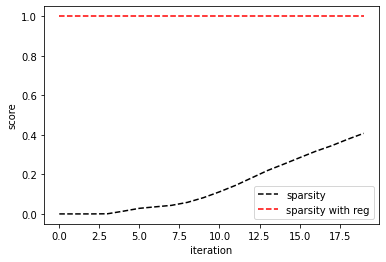

In [ ]:
plt.plot(model.score_tracker['sparsity'].value, "k--", label = 'sparsity')
plt.plot(model_reg.score_tracker['sparsity'].value, "r--" , label = 'sparsity with reg')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

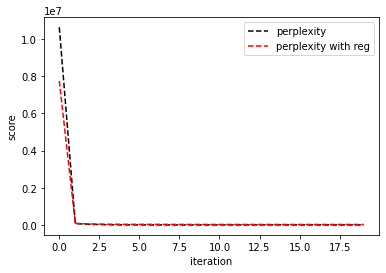

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, "k--", label = 'perplexity')
plt.plot(model_reg.score_tracker['perplexity'].value, "r--" , label = 'perplexity with reg')
plt.legend(loc = 'best')
plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens
for topic_name in model.topic_names: print(top_tokens[topic_name])

['учёный', 'исследование', 'который', 'исследователь', 'анализ', 'алкоголь', 'клетка', 'днк', 'человек', 'результат']
['английский', 'испания', 'испанский', 'англия', 'реал', 'барселона', 'манчестер', 'челси', 'лондонский', 'арсенал']
['свой', 'заявить', 'вызвать', 'слово', 'который', 'повод', 'назвать', 'мнение', 'заявление', 'критика']
['церковь', 'религиозный', 'храм', 'православный', 'кирилл', 'собор', 'патриарх', 'община', 'священник', 'монастырь']
['германия', 'запрет', 'немецкий', 'эстония', 'мвф', 'фрг', 'меркель', 'канцлер', 'страна', 'ангел']
['украина', 'украинский', 'киев', 'виктор', 'янукович', 'ющенко', 'страна', 'это', 'киевский', 'заявить']
['2012', 'год', '2013', 'реклама', 'который', 'это', 'кампания', 'рекламный', 'стать', 'подпись']
['август', 'журналист', 'ситуация', 'это', 'день', 'сложиться', 'праздник', 'ранее', 'стать', 'весь']
['газета', 'издание', 'писать', 'источник', 'данные', 'ссылка', 'коммерсант', 'отмечать', 'который', 'однако']
['индия', 'индийский', '

In [ ]:
top_tokens = model_reg.score_tracker['top-tokens'].last_tokens
for topic_name in model_reg.topic_names: print(top_tokens[topic_name])

['алкоголь', 'клетка', 'напиток', 'вещество', 'пиво', 'организм', 'алкогольный', 'ген', 'употребление', 'это']
['футболист', 'барселона', 'реал', 'клуб', 'манчестер', 'челси', 'чемпион', 'английский', 'лига', 'испанский']
['который', 'свой', 'заявить', 'слово', 'вызвать', 'внимание', 'назвать', 'критика', 'человек', 'мнение']
['южный', 'осетия', 'абхазия', 'зона', 'конфликт', 'республика', 'миротворец', 'территория', 'сторона', 'август']
['германия', 'немецкий', 'фрг', 'берлин', 'меркель', 'канцлер', 'евро', 'ангел', 'австрия', 'немец']
['российский', 'россия', 'рф', 'москва', 'заявление', 'это', 'заявить', 'мид', 'представитель', 'иностранный']
['реклама', 'рекламный', 'кампания', 'ролик', 'васильев', 'плакат', 'объявление', 'агентство', 'размещение', 'разместить']
['нога', 'рука', 'левый', 'жизнь', 'сердце', 'правый', 'почувствовать', 'палец', 'плохо', 'спасти']
['газета', 'директор', 'совет', 'писать', 'коммерсант', 'издание', 'генеральный', 'ведомость', 'источник', 'председатель']


In [ ]:
from sklearn.linear_model import LogisticRegression
with open('/content/drive/MyDrive/Tasks/Тask7/vw_data/y_train.vw.txt') as f: 
    y_train = f.read().split('\n')
with open('/content/drive/MyDrive/Tasks/Тask7/vw_data/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')
def classify(model, y_train = y_train, y_valid = y_valid): 
    X_train_pd = model.transform(bv_train)
    X_valid_pd = model.transform(bv_test)
    X_train = []
    X_valid = []
    for i in tqdm(range(len(y_valid))): X_valid.append(X_valid_pd[i].values)with open('drive/MyDrive/DATASETS/MachineLearning'
          '/topicmodeling/vw_data/y_train.vw.txt') as f:
    for i in tqdm(range(len(y_train))): X_train.append(X_train_pd[i].values)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train)
    X_train = X_train[:20000]
    y_train = y_train[:20000]
    clf = LogisticRegression(random_state = 42)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_valid)
    print(classification_report(y_valid, pred, zero_division = 1))

In [ ]:
_ = classify(model)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                      precision    recall  f1-score   support

             coцсети       1.00      0.00      0.00        39
                 nan       0.61      0.25      0.35       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       1.00      0.00      0.00        24
              бизнес       0.56      0.07      0.13        70
          бокс и мма       0.89      0.50      0.64        32
                вещи       1.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       1.00      0.00      0.00        16
                 все       0.65      0.98      0.78      3356
             гаджеты       1.00      0.21      0.34        24
               город       1.00      0.00      0.00        18
        госэкономика       0.49      0.31      0.38       162
                дача       1.00      0.00      0.00        13
       

In [ ]:
_ = classify(model_reg)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                      precision    recall  f1-score   support

             coцсети       0.67      0.10      0.18        39
                 nan       0.51      0.15      0.23       208
          автобизнес       1.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       1.00      0.00      0.00        24
              бизнес       0.75      0.04      0.08        70
          бокс и мма       0.84      0.50      0.63        32
                вещи       1.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       1.00      0.00      0.00        16
                 все       0.61      0.95      0.74      3356
             гаджеты       0.33      0.04      0.07        24
               город       1.00      0.00      0.00        18
        госэкономика       0.57      0.30      0.40       162
                дача       1.00      0.00      0.00        13
       

In [ ]:
#loading models
model = artm.load_artm_model('/content/drive/MyDrive/Tasks/Тask7/models/without_regularizators')
model_reg = artm.load_artm_model('/content/drive/MyDrive/Tasks/Тask7/models/with_regularizators')

In [ ]:
def find_modal(model):
    top_tokens = model.score_tracker['top-tokens'].last_tokens
    modal, mean_vectors = [], []
    with open(filename_train, 'r') as f:
        for line in tqdm(f):
            string = re.search(r'@year class_(\d\d\d\d)', line).group(1)
            modal.append(datetime.datetime.strptime(string, '%Y'))
    modal = np.array(modal)
    u_modal = np.unique(modal)
    predict = model.transform(bv_train)
    for mdl in tqdm(u_modal): mean_vectors.append(predict[np.where(modal == mdl)[0]].values.mean(axis = -1))
    mean_vectors = np.array(mean_vectors)
    for mdl_id, topic_id in zip(*np.where(mean_vectors > .01)):
        print(u_modal[mdl_id].strftime("%Y"),
              ", ".join(top_tokens[model.topic_names[topic_id]]))


In [ ]:
_ = find_modal(model)
#темы не очень информативные, много повторений


1914 война, нато, мировой, альянс, отечественный, великий, победа, день, честь, ветеран
1914 мужчина, летний, женщина, инцидент, произойти, попытаться, это, дом, нога, затем
1914 сказать, это, наш, слово, весь, заявить, добавить, отметить, подчеркнуть, который
1914 год, 2011, х, который, ссср, 1990, это, впоследствии, сообщать, время
1914 это, рассказать, очень, свой, весь, хотеть, слово, просто, который, отметить
1914 результат, погибнуть, человек, произойти, взрыв, погибший, получить, жертва, теракт, ранение
1914 хороший, премия, книга, церемония, награда, роман, получить, номинация, писатель, год
1914 военный, военнослужащий, армия, генерал, афганистан, солдат, офицер, войско, пакистан, операция
1914 машина, автомобиль, водитель, дорога, авария, дорожный, движение, дтп, находиться, автобус
1914 самолёт, борт, воздушный, полёт, пассажир, пилот, экипаж, лайнер, катастрофа, посадка
1914 ракета, система, испытание, способный, километр, комплекс, установка, ракетный, цель, дальность
191

In [ ]:
_ = find_modal(model_reg)


1914 германия, немецкий, фрг, берлин, меркель, канцлер, евро, ангел, австрия, немец
1914 нога, рука, левый, жизнь, сердце, правый, почувствовать, палец, плохо, спасти
1914 поезд, железнодорожный, железный, дорога, ржд, оао, госкорпорация, вагон, компания, ооо
1914 год, х, 2000, 2005, итальянский, 2004, 2003, 1990, 2006, стать
1914 сталин, михалков, никита, телеведущий, познер, кинематографист, любовь, пугачев, малахов, сказка
1914 погибший, человек, погибнуть, тело, причина, катастрофа, находиться, результат, пропасть, который
1914 премия, хороший, награда, церемония, получить, номинация, год, приз, лауреат, звание
1914 военный, военнослужащий, афганистан, армия, солдат, генерал, войско, офицер, сила, пакистан
1914 машина, автомобиль, водитель, дорога, движение, автобус, дтп, дорожный, авария, грузовик
1914 война, советский, год, памятник, ссср, день, великий, мировой, ветеран, память
1914 самолёт, авиакомпания, пассажир, полёт, борт, рейс, аэропорт, пилот, лайнер, воздушный
1914 раке

Стоит заметить, что как года модели без регуляризатора недостаточно для полноценного предсказания тега новости, нужна по идее вся дата, как было на семинаре. Итого, тематическая модель формирует достаточно информативный вектор для классификации тегов. Минус в том, что всё это выполняется пугающе долго, без поддержки `GPU`